## Ranking from Binary Comparisons

In this task there are a set $\mathcal{O}$ of $N$ objects with some intrinsic value $v : \mathcal{O} \to \mathbb{R}$, and $M$ raters who can determine relative ordering of value between two objects, $r : \mathcal{O} \times \mathcal{O} \to \{0, 1\}$. That is, the raters are not able to measure the value of each object or even the relative value between objects. Rather, they can only say whether one objects value is higher or lower than another. In this example we do not allow raters to assign equal value between objects.

Each rater provides $Q$ ratings between $Q$ random unique pairs of objects, and has a chance $p$ of getting it wrong. For rater $i$, and objects $j$ and $k$, define the rating $r_ijk$ as 1 if $v(o_j) > v(o_k)$ and 0 otherwise.

The objective of the experimenter is to deduce the relative value of each object on a given scale.

In this example, we will let that scale be the 5 star rating system, so that each object in $\mathcal{O}$ will be assigned on a value in $[1, 5]$ (inclusive).

To do this we apply a prior that each object $o_i \in \mathcal{O}$ has a value $v(o_i) \triangleq v_i \sim \mathcal{U}[1,5]$, and then form a likelihood which is the sum of violated constraints.


$L(v_{i:T}) = \sum_{ijk} r_{ijk} \mathbb{1}(v(o_j) < v(o_k))$

In [8]:
from jax import numpy as jnp, random, jit
from jaxns import NestedSampler, PriorChain
from jaxns import save_results, load_results, marginalise_dynamic
from jaxns.prior_transforms import UniformPrior
from jaxns.plotting import plot_diagnostics, plot_cornerplot
from jaxns.utils import summary, resample
from itertools import combinations

In [3]:


def get_constraints(num_options, num_raters, tests_per_rater, p_wrong):
    key, true_key = random.split(random.PRNGKey(47573957), 2)
    actual_rank = random.uniform(true_key,shape=(num_options,),minval=1., maxval=5.)

    pairs = jnp.asarray(list(combinations(range(num_options), 2)), dtype=jnp.int_)
    I = []
    J = []
    S = []
    for rater in range(num_raters):
        key, sample_key1, sample_key2, sample_key3 = random.split(key, 4)
        choices = random.choice(sample_key1,pairs.shape[0], shape=(tests_per_rater,), replace=False)
        I.append(pairs[choices,0])
        J.append(pairs[choices,1])
        guess = jnp.where(random.uniform(sample_key1) < p_wrong,
                        actual_rank[I[-1]] < actual_rank[J[-1]], # wrong
        actual_rank[I[-1]] > actual_rank[J[-1]] # right
                          )
        S.append(guess)

    return actual_rank, jnp.concatenate(I),jnp.concatenate(J),jnp.concatenate(S)

In [16]:

num_options=10
num_raters=20
tests_per_rater=3
p_wrong=0.1

actual_rank, I, J, S = get_constraints(num_options, num_raters, tests_per_rater, p_wrong=p_wrong)

/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3610: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")


In [17]:

def log_likelihood(rank):
    order = rank[I] > rank[J]
    violations = jnp.sum(order != S)
    return -violations

with PriorChain() as prior_chain:
    UniformPrior('rank', jnp.ones(num_options), 5*jnp.ones(num_options))

ns = NestedSampler(loglikelihood=log_likelihood,
                   prior_chain=prior_chain,
                   sampler_kwargs=dict(gradient_boost=True))

results = ns(random.PRNGKey(32564),
             termination_max_num_steps=40,
             maximise_likelihood=True)
save_results(results, 'ranking_save.npz')
# results = load_results('ranking_save.npz')

/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3662: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")
WARNING[2022-03-25 18:03:12,321]: Increasing max_samples (100000) by 1000 to evenly divide samples_per_step
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3610: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/

--------
Termination Conditions:
Used max num steps
--------
# likelihood evals: 2386333
# samples: 41000
# likelihood evals / sample: 58.2
--------
logZ=-17.374 +- 0.077
H=nan
ESS=730
--------
rank[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.


WARNING[2022-03-25 18:03:23,559]: No handles with labels found to put in legend.


rank[0]: 2.47 +- 0.56 | 1.74 / 2.42 / 3.2 | 2.45 | 2.25
rank[1]: 2.76 +- 0.65 | 1.85 / 2.82 / 3.52 | 2.45 | 2.38
rank[2]: 3.22 +- 0.61 | 2.43 / 3.25 / 3.98 | 3.28 | 3.84
rank[3]: 3.84 +- 0.64 | 2.98 / 3.91 / 4.63 | 3.48 | 4.29
rank[4]: 3.93 +- 0.69 | 3.0 / 3.97 / 4.82 | 3.77 | 2.91
rank[5]: 1.89 +- 0.51 | 1.27 / 1.8 / 2.64 | 2.32 | 1.84
rank[6]: 3.9 +- 0.61 | 3.04 / 3.94 / 4.66 | 4.29 | 4.18
rank[7]: 2.05 +- 0.64 | 1.33 / 1.92 / 2.92 | 2.4 | 1.89
rank[8]: 4.49 +- 0.44 | 3.88 / 4.6 / 4.94 | 4.34 | 4.35
rank[9]: 1.44 +- 0.39 | 1.06 / 1.33 / 1.91 | 2.1 | 1.47
--------


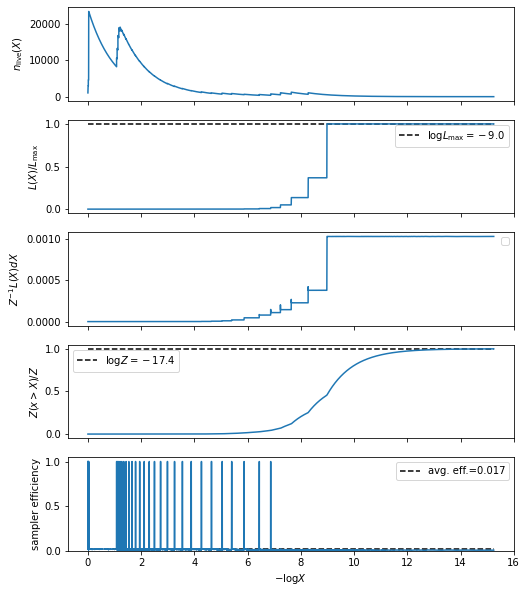

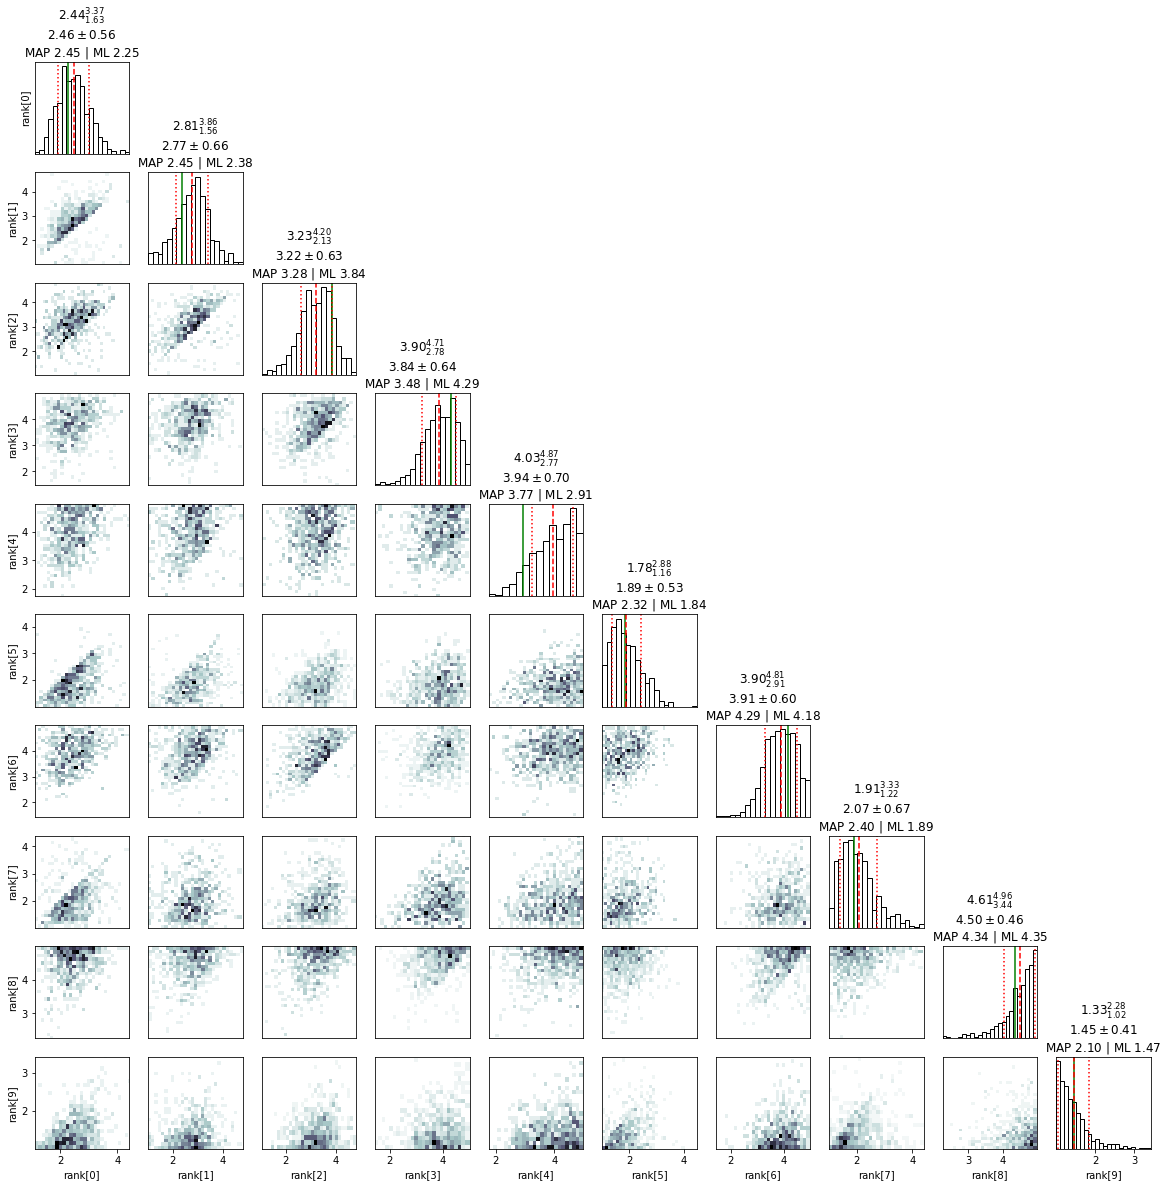

In [18]:

summary(results)
plot_diagnostics(results)
plot_cornerplot(results, vars=['rank'])

In [19]:
# The maximum likelihood estimate has to fewest violation

rank_L_max_estimate = results.sample_L_max['rank']
log_L_max = results.log_L_max
print(f"Number of violations at maximum likelihood estimate: {-log_L_max}")

# Compare to median of posterior
samples = resample(random.PRNGKey(245944), results.samples, results.log_dp_mean, S=int(results.ESS))
rank_median_estimate = jnp.median(samples['rank'], axis=0)
log_L_median_post = log_likelihood(rank_median_estimate)
print(f"Number of violations at median of posterior: {-log_L_median_post}")

log_L_actual = log_likelihood(actual_rank)
print(f"Number of violations at actual rank: {-log_L_actual}")

for i in range(num_options):
    print(f"Option {i}: True rank={actual_rank[i]}, L_Max rank={rank_L_max_estimate[i]}, median posterior rank={rank_median_estimate[i]}")

Number of violations at maximum likelihood estimate: 9.0
Number of violations at median of posterior: 9
Number of violations at actual rank: 9
Option 0: True rank=2.3695788383483887, L_Max rank=2.2519259452819824, median posterior rank=2.408155918121338
Option 1: True rank=2.6293601989746094, L_Max rank=2.3824949264526367, median posterior rank=2.859787940979004
Option 2: True rank=2.764465808868408, L_Max rank=3.843040704727173, median posterior rank=3.3061251640319824
Option 3: True rank=3.8243227005004883, L_Max rank=4.291561126708984, median posterior rank=3.8912792205810547
Option 4: True rank=2.954990863800049, L_Max rank=2.9144506454467773, median posterior rank=4.074360370635986
Option 5: True rank=2.3232431411743164, L_Max rank=1.8359400033950806, median posterior rank=1.818422555923462
Option 6: True rank=4.1021881103515625, L_Max rank=4.176526069641113, median posterior rank=3.9665420055389404
Option 7: True rank=1.4255428314208984, L_Max rank=1.889859676361084, median poste

In [20]:
# Lets set what the relative order is.
# Posterior predictive ordering
ordering_marginalised = marginalise_dynamic(random.PRNGKey(42), results.samples, results.log_dp_mean, results.ESS, lambda rank: jnp.argsort(rank))
ordering_L_max = jnp.argsort(rank_L_max_estimate)
ordering_median_posterior = jnp.argsort(rank_median_estimate)
ordering_true = jnp.argsort(actual_rank)
for i in range(num_options):
    print(f"True rank = {ordering_true[i]}, max(L) rank = {ordering_L_max[i]}, mean_posterior_ordering={ordering_median_posterior[i]}, marinalised rank= {ordering_marginalised[i]}")

True rank = 9, max(L) rank = 9, mean_posterior_ordering=9, marinalised rank= 8.259918212890625
True rank = 7, max(L) rank = 5, mean_posterior_ordering=5, marinalised rank= 6.03009557723999
True rank = 5, max(L) rank = 7, mean_posterior_ordering=7, marinalised rank= 5.186046600341797
True rank = 0, max(L) rank = 0, mean_posterior_ordering=0, marinalised rank= 0.8262653946876526
True rank = 1, max(L) rank = 1, mean_posterior_ordering=1, marinalised rank= 1.685362458229065
True rank = 2, max(L) rank = 4, mean_posterior_ordering=2, marinalised rank= 2.5854992866516113
True rank = 4, max(L) rank = 2, mean_posterior_ordering=3, marinalised rank= 3.850889205932617
True rank = 3, max(L) rank = 6, mean_posterior_ordering=6, marinalised rank= 4.425444602966309
True rank = 6, max(L) rank = 3, mean_posterior_ordering=4, marinalised rank= 5.261285781860352
True rank = 8, max(L) rank = 8, mean_posterior_ordering=8, marinalised rank= 6.889193058013916
